In [23]:
import os
import numpy as np
import librosa
from scipy.signal import medfilt
import kagglehub

# Download dataset from Kaggle
voice_path = kagglehub.dataset_download("dipayanbiswas/parkinsons-disease-speech-signal-features")
print("Path to dataset files:", voice_path)

# The dataset is usually a CSV with features
import pandas as pd
voice_df = pd.read_csv(os.path.join(voice_path, "pd_speech_features.csv"))
print(voice_df.head())



Using Colab cache for faster access to the 'parkinsons-disease-speech-signal-features' dataset.
Path to dataset files: /kaggle/input/parkinsons-disease-speech-signal-features
   id  gender      PPE      DFA     RPDE  numPulses  numPeriodsPulses  \
0   0       1  0.85247  0.71826  0.57227        240               239   
1   0       1  0.76686  0.69481  0.53966        234               233   
2   0       1  0.85083  0.67604  0.58982        232               231   
3   1       0  0.41121  0.79672  0.59257        178               177   
4   1       0  0.32790  0.79782  0.53028        236               235   

   meanPeriodPulses  stdDevPeriodPulses  locPctJitter  ...  \
0          0.008064            0.000087       0.00218  ...   
1          0.008258            0.000073       0.00195  ...   
2          0.008340            0.000060       0.00176  ...   
3          0.010858            0.000183       0.00419  ...   
4          0.008162            0.002669       0.00535  ...   

   tqwt_kurto

In [24]:
# Drop non-feature columns (like ID, labels)
features = voice_df.drop(columns=['id', 'class'], errors='ignore')
labels = voice_df['class']  # Parkinson’s vs Healthy
print("Feature shape:", features.shape, "Labels shape:", labels.shape)


Feature shape: (756, 753) Labels shape: (756,)


In [25]:
# This code assumes you have X and y from the previous step
from sklearn.preprocessing import StandardScaler
# --- Step 3: Scale the features ---
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# X_scaled is a NumPy array, which is ready for the next steps
print("\nFeatures have been successfully scaled.")


Features have been successfully scaled.


In [26]:
np.save('voice_features_scaled.npy', scaled_features)
np.save('voice_labels.npy', labels)
print("Scaled voice features and labels have been saved successfully.")
print("Files created: 'voice_features_scaled.npy' and 'voice_labels.npy'")

Scaled voice features and labels have been saved successfully.
Files created: 'voice_features_scaled.npy' and 'voice_labels.npy'


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels, test_size=0.2, random_state=42, stratify=labels)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (604, 753)
Shape of X_test: (152, 753)
Shape of y_train: (604,)
Shape of y_test: (152,)


In [28]:
import numpy as np
import os
import glob
import cv2
from sklearn.preprocessing import LabelEncoder

# --- TensorFlow and Keras Imports ---
try:
    from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.models import Model
except ImportError:
    print("TensorFlow not found. Please install it using: pip install tensorflow")
    exit()

# --- Kaggle Dataset Download ---
# This block is for users who have kagglehub installed and configured.
# If you have the data locally, you can comment this out and set `hand_path` manually.
try:
    import kagglehub
    print("--- Downloading Kaggle dataset ---")
    hand_path = kagglehub.dataset_download("kmader/parkinsons-drawings")
    print("Dataset path:", hand_path)
except ImportError:
    print("Warning: kagglehub not found. Assuming data is in a local directory named 'parkinsons-drawings'.")
    hand_path = "parkinsons-drawings" #<-- If data is local, set path here
except Exception as e:
    print(f"An error occurred during download: {e}")
    print("Please ensure you are logged into Kaggle and have accepted the dataset terms.")
    exit()


# --- 1. Load the Pre-trained Model (VGG16) ---
print("\n--- Loading VGG16 model for feature extraction ---")
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# We don't need to train the VGG16 layers, just use them.
for layer in base_model.layers:
    layer.trainable = False
print("Model loaded successfully.\n")


# --- 2. Define Image Augmentation ---
print("--- Setting up image data augmentation ---")
# Create an ImageDataGenerator for creating altered versions of images
# These parameters are chosen to be mild, suitable for handwriting.
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode='nearest'
)
N_AUGMENTATIONS_PER_IMAGE = 5 # Create 5 new images for each original one

# --- 3. Find and Process all Images ---
print("--- Finding, augmenting, and processing handwriting images ---")
# Recursive search for all png files in the dataset directory
hand_files = glob.glob(os.path.join(hand_path, "**/*.png"), recursive=True)
if not hand_files:
    print(f"Error: No PNG files found in the directory: {hand_path}")
    exit()

features_list = []
labels_list = []

for file in hand_files:
    # Extract label from parent folder name
    label = os.path.basename(os.path.dirname(file)) # More robust way to get parent folder

    # --- Image Loading and Preparation ---
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))
    # Convert to numpy array and add batch dimension for processing
    img_batch = np.expand_dims(img, axis=0)

    # --- Process the ORIGINAL Image First ---
    # Use the specific VGG16 preprocessing function
    img_preprocessed = preprocess_input(img_batch.copy())
    features = base_model.predict(img_preprocessed, verbose=0)
    features_list.append(features.flatten())
    labels_list.append(label)

    # --- Create and Process AUGMENTED Images ---
    # Create a generator that will produce augmented versions of our image
    aug_iterator = datagen.flow(img_batch, batch_size=1)

    for _ in range(N_AUGMENTATIONS_PER_IMAGE):
        # Get one augmented image
        aug_img_batch = next(aug_iterator)

        # Preprocess the augmented image for VGG16
        aug_img_preprocessed = preprocess_input(aug_img_batch.copy())

        # Extract features from the augmented image
        aug_features = base_model.predict(aug_img_preprocessed, verbose=0)

        features_list.append(aug_features.flatten())
        labels_list.append(label)


print(f"Processed {len(hand_files)} original images and generated {len(hand_files) * N_AUGMENTATIONS_PER_IMAGE} augmented images.")
print(f"Total feature vectors created: {len(features_list)}\n")

# --- 4. Encode Labels and Combine Data ---
# Convert string labels ('healthy', 'parkinson') to integers (0, 1)
le = LabelEncoder()
encoded_labels = le.fit_transform(labels_list)
print(f"Label classes found: {le.classes_}\n")

all_features = np.array(features_list)
all_labels = np.array(encoded_labels)


# --- 5. Save the Extracted Features ---
print("--- Saving extracted features and labels to files ---")
np.save('handwriting_features.npy', all_features)
np.save('handwriting_labels.npy', all_labels)

print(f"Saved handwriting features with shape: {all_features.shape}")
print(f"Saved handwriting labels with shape: {all_labels.shape}")



--- Downloading Kaggle dataset ---


100%|██████████| 41.4M/41.4M [00:00<00:00, 147MB/s] 

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/kmader/parkinsons-drawings/versions/1

--- Loading VGG16 model for feature extraction ---
Model loaded successfully.

--- Setting up image data augmentation ---
--- Finding, augmenting, and processing handwriting images ---
Processed 408 original images and generated 2040 augmented images.
Total feature vectors created: 2448

Label classes found: ['healthy' 'parkinson']

--- Saving extracted features and labels to files ---
Saved handwriting features with shape: (2448, 25088)
Saved handwriting labels with shape: (2448,)


In [29]:
import numpy as np
import os
import glob
import cv2
from sklearn.preprocessing import LabelEncoder

# --- TensorFlow and Keras Imports ---
try:
    from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.models import Model
except ImportError:
    print("TensorFlow not found. Please install it using: pip install tensorflow")
    exit()

# --- Kaggle Dataset Download ---
# This block is for users who have kagglehub installed and configured.
# If you have the data locally, you can comment this out and set `hand_path` manually.
try:
    import kagglehub
    print("--- Downloading Kaggle dataset ---")
    mri_path = kagglehub.dataset_download("irfansheriff/parkinsons-brain-mri-dataset")
    print("Dataset path:", mri_path)
except ImportError:
    print("Warning: kagglehub not found. Assuming data is in a local directory named 'parkinsons-drawings'.")
    hand_path = "parkinsons-drawings" #<-- If data is local, set path here
except Exception as e:
    print(f"An error occurred during download: {e}")
    print("Please ensure you are logged into Kaggle and have accepted the dataset terms.")
    exit()


# --- 1. Load the Pre-trained Model (VGG16) ---
print("\n--- Loading VGG16 model for feature extraction ---")
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# We don't need to train the VGG16 layers, just use them.
for layer in base_model.layers:
    layer.trainable = False
print("Model loaded successfully.\n")


# --- 2. Define Image Augmentation ---
print("--- Setting up image data augmentation ---")
# Create an ImageDataGenerator for creating altered versions of images
# These parameters are chosen to be mild, suitable for handwriting.
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode='nearest'
)
N_AUGMENTATIONS_PER_IMAGE = 5 # Create 5 new images for each original one

# --- 3. Find and Process all Images ---
print("--- Finding, augmenting, and processing mri images ---")
# Recursive search for all png files in the dataset directory
mri_files = glob.glob(os.path.join(mri_path, "**/*.png"), recursive=True)
if not mri_files:
    print(f"Error: No PNG files found in the directory: {mri_path}")
    exit()

features_list = []
labels_list = []

for file in mri_files:
    # Extract label from parent folder name
    label = os.path.basename(os.path.dirname(file)) # More robust way to get parent folder

    # --- Image Loading and Preparation ---
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))
    # Convert to numpy array and add batch dimension for processing
    img_batch = np.expand_dims(img, axis=0)

    # --- Process the ORIGINAL Image First ---
    # Use the specific VGG16 preprocessing function
    img_preprocessed = preprocess_input(img_batch.copy())
    features = base_model.predict(img_preprocessed, verbose=0)
    features_list.append(features.flatten())
    labels_list.append(label)

    # --- Create and Process AUGMENTED Images ---
    # Create a generator that will produce augmented versions of our image
    aug_iterator = datagen.flow(img_batch, batch_size=1)

    for _ in range(N_AUGMENTATIONS_PER_IMAGE):
        # Get one augmented image
        aug_img_batch = next(aug_iterator)

        # Preprocess the augmented image for VGG16
        aug_img_preprocessed = preprocess_input(aug_img_batch.copy())

        # Extract features from the augmented image
        aug_features = base_model.predict(aug_img_preprocessed, verbose=0)

        features_list.append(aug_features.flatten())
        labels_list.append(label)


print(f"Processed {len(mri_files)} original images and generated {len(mri_files) * N_AUGMENTATIONS_PER_IMAGE} augmented images.")
print(f"Total feature vectors created: {len(features_list)}\n")

# --- 4. Encode Labels and Combine Data ---
# Convert string labels ('healthy', 'parkinson') to integers (0, 1)
le = LabelEncoder()
encoded_labels = le.fit_transform(labels_list)
print(f"Label classes found: {le.classes_}\n")

all_features = np.array(features_list)
all_labels = np.array(encoded_labels)


# --- 5. Save the Extracted Features ---
print("--- Saving extracted features and labels to files ---")
np.save('mri_features.npy', all_features)
np.save('mri_labels.npy', all_labels)

print(f"Saved mri features with shape: {all_features.shape}")
print(f"Saved mri labels with shape: {all_labels.shape}")



--- Downloading Kaggle dataset ---
Using Colab cache for faster access to the 'parkinsons-brain-mri-dataset' dataset.
Dataset path: /kaggle/input/parkinsons-brain-mri-dataset

--- Loading VGG16 model for feature extraction ---
Model loaded successfully.

--- Setting up image data augmentation ---
--- Finding, augmenting, and processing mri images ---
Processed 831 original images and generated 4155 augmented images.
Total feature vectors created: 4986

Label classes found: ['normal' 'parkinson']

--- Saving extracted features and labels to files ---
Saved mri features with shape: (4986, 25088)
Saved mri labels with shape: (4986,)


--- Loading preprocessed voice data ---
Voice data loaded successfully.
Voice features shape: (756, 753)
Voice labels shape: (756,)

--- Loading pre-extracted handwriting data ---
Handwriting data loaded successfully.
Handwriting features shape: (2448, 25088)
Handwriting labels shape: (2448,)

--- Loading pre-extracted MRI data ---
MRI data loaded successfully.
MRI features shape: (4986, 25088)
MRI labels shape: (4986,)

--- Aligning datasets ---
All datasets aligned to 756 samples.

--- Splitting data into training and testing sets ---
Data split successfully.

--- Building the regularized 3-branch fusion model ---


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ voice_input         │ (None, 753)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ handwriting_input   │ (None, 25088)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mri_input           │ (None, 25088)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 32)        │     24,128 │ voice_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 128)       │  3,211,392 │ handwriting_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 128)       │  3,211,392 │ mri_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 32)        │          0 │ dense_56[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ dense_58[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 128)       │          0 │ dense_60[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 16)        │        528 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 64)        │      8,256 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 64)        │      8,256 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 144)       │          0 │ dense_57[0][0],   │
│ (Concatenate)       │                   │            │ dense_59[0][0],   │
│                     │                   │            │ dense_61[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 64)        │      9,280 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 64)        │          0 │ dense_62[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │         65 │ dropout_26[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,473,297 (24.69 MB)

 Trainable params: 6,473,297 (24.69 MB)

 Non-trainable params: 0 (0.00 B)


--- Training the model ---
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 342ms/step - accuracy: 0.6056 - loss: 8.3532 - val_accuracy: 0.6942 - val_loss: 3.4057
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6537 - loss: 6.5450 - val_accuracy: 0.7025 - val_loss: 1.7460
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6836 - loss: 3.3996 - val_accuracy: 0.7025 - val_loss: 1.7222
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6499 - loss: 2.8089 - val_accuracy: 0.6860 - val_loss: 1.3368
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7391 - loss: 1.9937 - val_accuracy: 0.6942 - val_loss: 1.2322
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6875 - loss: 1.7507 - val_accuracy: 0.7107 - val_loss: 1.1040
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6694 - loss: 1.5040 - val_accuracy: 0.7355 - val_loss: 1.0923
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7297 - l

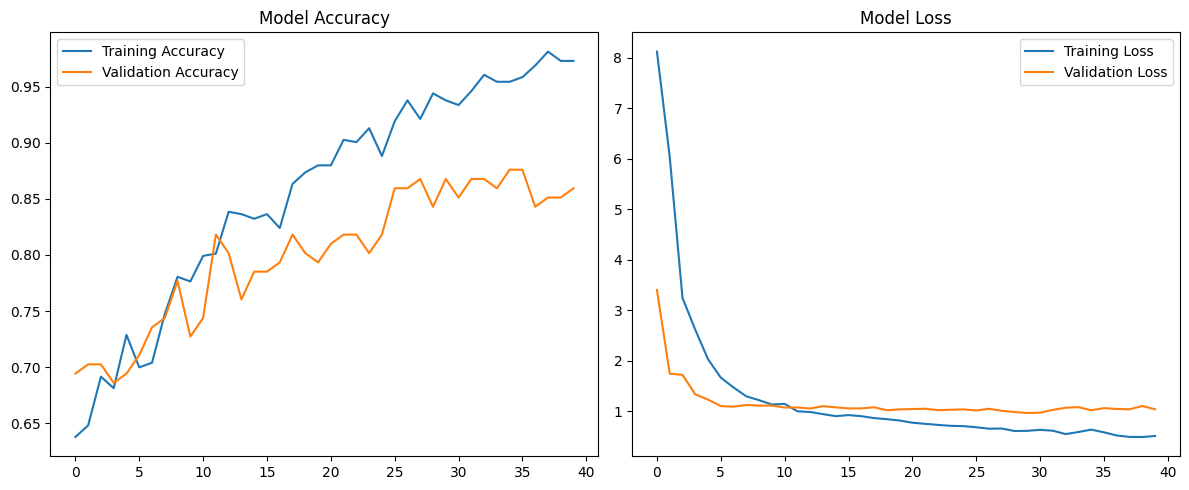

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split

# --- TensorFlow and Keras Imports ---
try:
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.utils import plot_model
except ImportError:
    print("TensorFlow not found. Please install it using: pip install tensorflow")
    exit()

# --- Matplotlib for plotting ---
try:
    import matplotlib.pyplot as plt
except ImportError:
    print("Matplotlib not found. Please install it using: pip install matplotlib")
    plt = None

# --- 1. Load All Preprocessed Data ---
print("--- Loading preprocessed voice data ---")
try:
    features_voice = np.load('voice_features_scaled.npy')
    labels_voice = np.load('voice_labels.npy')
    print("Voice data loaded successfully.")
    print(f"Voice features shape: {features_voice.shape}")
    print(f"Voice labels shape: {labels_voice.shape}\n")
except FileNotFoundError:
    print("Error: Voice data files not found. Please run the voice_preprocessing.py script first.")
    exit()

print("--- Loading pre-extracted handwriting data ---")
try:
    features_hand = np.load('handwriting_features.npy')
    labels_hand = np.load('handwriting_labels.npy')
    print("Handwriting data loaded successfully.")
    print(f"Handwriting features shape: {features_hand.shape}")
    print(f"Handwriting labels shape: {labels_hand.shape}\n")
except FileNotFoundError:
    print("Error: Handwriting feature files not found. Please run the handwriting_feature_extraction.py script first.")
    exit()

print("--- Loading pre-extracted MRI data ---")
try:
    features_mri = np.load('mri_features.npy')
    labels_mri = np.load('mri_labels.npy')
    print("MRI data loaded successfully.")
    print(f"MRI features shape: {features_mri.shape}")
    print(f"MRI labels shape: {labels_mri.shape}\n")
except FileNotFoundError:
    print("Error: MRI feature files not found. Please run the mri_feature_extraction.py script first.")
    exit()

# --- 2. Align Datasets ---
print("--- Aligning datasets ---")
min_samples = min(len(labels_voice), len(labels_hand), len(labels_mri))

# Trim all datasets to the minimum number of samples
features_voice_aligned = features_voice[:min_samples]
features_hand_aligned = features_hand[:min_samples]
features_mri_aligned = features_mri[:min_samples]

# Use one set of labels as the ground truth
final_labels = labels_voice[:min_samples]

print(f"All datasets aligned to {min_samples} samples.\n")


# --- 3. Split Data for Training and Testing ---
print("--- Splitting data into training and testing sets ---")
X_train_voice, X_test_voice, \
X_train_hand, X_test_hand, \
X_train_mri, X_test_mri, \
y_train, y_test = train_test_split(
    features_voice_aligned,
    features_hand_aligned,
    features_mri_aligned,
    final_labels,
    test_size=0.2,
    random_state=42,
    stratify=final_labels
)
print("Data split successfully.\n")


# --- 4. Define the 3-Branch Fusion Model Architecture ---
print("--- Building the regularized 3-branch fusion model ---")
l2_rate = 0.001

# Branch 1: Voice Data
voice_input = Input(shape=(X_train_voice.shape[1],), name='voice_input')
x1 = Dense(32, activation='relu', kernel_regularizer=l2(l2_rate))(voice_input)
x1 = Dropout(0.5)(x1)
voice_output = Dense(16, activation='relu', kernel_regularizer=l2(l2_rate))(x1)

# Branch 2: Handwriting Data
hand_input = Input(shape=(X_train_hand.shape[1],), name='handwriting_input')
x2 = Dense(128, activation='relu', kernel_regularizer=l2(l2_rate))(hand_input)
x2 = Dropout(0.5)(x2)
hand_output = Dense(64, activation='relu', kernel_regularizer=l2(l2_rate))(x2)

# Branch 3: MRI Data
mri_input = Input(shape=(X_train_mri.shape[1],), name='mri_input')
x3 = Dense(128, activation='relu', kernel_regularizer=l2(l2_rate))(mri_input)
x3 = Dropout(0.5)(x3)
mri_output = Dense(64, activation='relu', kernel_regularizer=l2(l2_rate))(x3)

# Fusion: Concatenate the outputs of all three branches
concatenated = concatenate([voice_output, hand_output, mri_output])

# Final Classifier Head
fusion_layer = Dense(64, activation='relu', kernel_regularizer=l2(l2_rate))(concatenated)
fusion_layer = Dropout(0.5)(fusion_layer)
output = Dense(1, activation='sigmoid', name='final_output')(fusion_layer)

# Create the final model
model = Model(inputs=[voice_input, hand_input, mri_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# --- 5. Train the Model ---
print("\n--- Training the model ---")
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    [X_train_voice, X_train_hand, X_train_mri],
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# --- 6. Evaluate the Model ---
print("\n--- Evaluating the model on the test set ---")
loss, accuracy = model.evaluate([X_test_voice, X_test_hand, X_test_mri], y_test)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# --- 7. Plot Training History ---
if plt:
    print("\n--- Plotting training history ---")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()



--- Generating confusion matrix ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


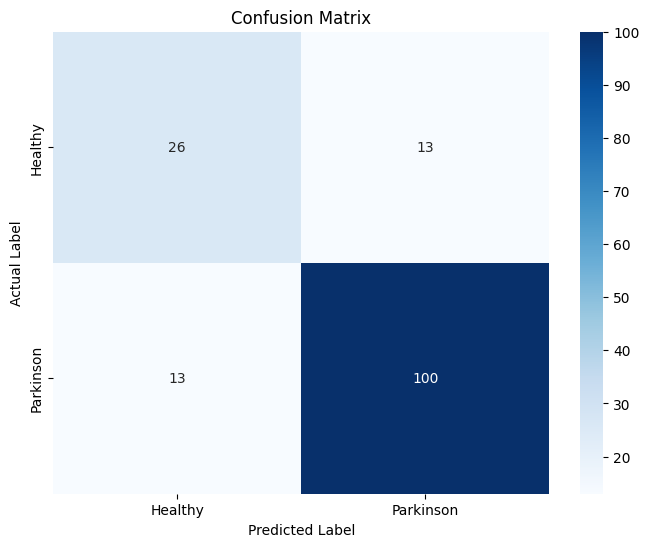

Confusion matrix plot saved as 'confusion_matrix.png'


In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

if plt and sns:
    print("\n--- Generating confusion matrix ---")
    # Get model's predictions on the test set
    y_pred_prob = model.predict([X_test_voice, X_test_hand, X_test_mri])
    # Convert prediction probabilities to binary class labels (0 or 1)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix as a heatmap for better visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Healthy', 'Parkinson'],
                yticklabels=['Healthy', 'Parkinson'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    print("Confusion matrix plot saved as 'confusion_matrix.png'")